In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

plt.style.use('seaborn-whitegrid')
logging.basicConfig(level=logging.CRITICAL)

/tmp/ipykernel_4019930/470066024.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
def plot_agg_learning_curves(fleet, ax=None, name=None, tasks=None, agent_ids=None, viz=True, mode="current",
                             metric="test_acc"):
    if ax is None and viz:
        fig, ax = plt.subplots()

    if tasks is None:
        tasks = range(fleet.num_init_tasks-1, fleet.num_tasks)

    dfs = []
    for agent in fleet.agents:
        if agent_ids is not None and agent.node_id not in agent_ids:
            continue
        df = agent.get_record().df
        for task in tasks:
            task_df = df[df["train_task"] == task]
            if mode == "current":
                task_df = task_df[task_df["test_task"] == str(task)]
            elif mode == "avg":
                task_df = task_df[task_df["test_task"] == 'avg']
            else:
                raise ValueError("mode must be current or avg")
            task_df['agent_id'] = agent.node_id
            # print(task_df)
            dfs.append(task_df)

    combined_df = pd.concat(dfs)

    agg_df = combined_df.groupby(['epoch']).agg({metric: ['mean', 'std']}).reset_index()

    # Extract mean and standard deviation values
    mean_test_acc = agg_df[metric]['mean']
    std_test_acc = agg_df[metric]['std']

    if viz:
        # Plot the mean test_acc with shaded areas for standard deviation
        ax.plot(agg_df['epoch'], mean_test_acc, 
                label=name)
        plt.fill_between(agg_df['epoch'], mean_test_acc - 0.1 * std_test_acc, mean_test_acc + 0.1 * std_test_acc, alpha=0.3)

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Test Accuracy')
        if name is not None:
            ax.legend();

    # compute area under the curve
    auc = np.trapz(mean_test_acc, agg_df['epoch'])
    return auc, agg_df

In [4]:
class FakeRecord:
    def __init__(self, df):
        self.df = df

class FakeAgent:
    def __init__(self, save_dir, node_id):
        self.node_id = node_id
        self.save_dir = save_dir


    def get_record(self):
        return FakeRecord(pd.read_csv(os.path.join(self.save_dir, "record.csv")))

class FakeFleet:
    def __init__(self, save_dir, num_init_tasks=4):
        self.save_dir = save_dir
        self.num_init_tasks = num_init_tasks
        self.num_tasks = 20 if "cifar100" in save_dir else 10
        self.agents = [FakeAgent(os.path.join(save_dir, agent_id), agent_id) for agent_id in os.listdir(save_dir) if agent_id != "hydra_out" and agent_id != "agent_69420"]
    
    def load_records(self):
        pass

def setup_fake_fleet(result_dir, modify_cfg=None, parallel=False):
    return FakeFleet(result_dir)

In [5]:
def load_data(get_save_dirs, seeds, datasets, modify_cfg, viz, tasks, agent_ids, ax=None, mode="current", 
              metric="test_acc"):
    dataset_seed_aucs = {}
    dataset_agg_dfs = {}
    for dataset in datasets:
        seed_aucs = {}
        agg_dfs = []
        for seed in seeds:
            fleets = {}
            save_dirs = get_save_dirs(dataset, seed)
            for name, save_dir in save_dirs.items():
                    # fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)
                    fleet = setup_fake_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)
                    fleet.load_records()
                    fleets[name] = fleet

            if viz:
                fig, ax = plt.subplots()

            aucs = {}
            for title_name, fleet in fleets.items():
                aucs[title_name], agg_df = plot_agg_learning_curves(fleet, ax, name=title_name, tasks=tasks, agent_ids=agent_ids, viz=viz, mode=mode,
                                                                    metric=metric)
                agg_df['seed'] = seed
                agg_df['name'] = title_name
                agg_dfs.append(agg_df)

            combined_agg_df = pd.concat(agg_dfs)
            seed_aucs[seed] = aucs
        
        dataset_seed_aucs[dataset] = seed_aucs
        dataset_agg_dfs[dataset] = combined_agg_df
    
    return dataset_seed_aucs, dataset_agg_dfs

In [6]:
def plot_agg_over_seeds(combined_agg_df, title_name=None, ax=None, std_scale=1.0, metric='test_acc',
                        remap_name=None):
    if title_name is None:
        title_name ='Aggregated Test Accuracy Learning Curves Across All Seeds and Algorithms'
    if ax is None:
        fig, ax = plt.subplots()
    
    agg_over_seed_name = combined_agg_df.groupby(['name', 'epoch']).agg({(metric, 'mean'): 'mean', (metric, 'std'): 'std'}).reset_index()

    for name, group in agg_over_seed_name.groupby('name'):
        if remap_name is not None and name not in remap_name:
            continue

        name = name if remap_name is None else remap_name[name]
        mean_test_acc = group[metric]['mean']
        std_test_acc = group[metric]['std']
        ax.plot(group['epoch'], mean_test_acc, label=name, marker='o')
        ax.fill_between(group['epoch'], mean_test_acc - std_scale * std_test_acc, mean_test_acc + std_scale * std_test_acc, alpha=0.3)

    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Test Accuracy', fontsize=14)
    ax.set_title(title_name, fontsize=16)
    # Setting legend font size
    ax.legend(frameon=True, loc='lower right', fontsize=12)
    # Setting x and y ticks font size
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    ax.grid(True, which='major', linestyle='--', alpha=0.5)
    # ax.set_ylim(0.4, 1);


In [7]:
def plot_learning_curve_bars(seed_aucs, title_name=None, ax=None, remap_name=None):
    if title_name is None:
        title_name = 'Aggregated AUC'
    
    if ax is None:
        fig, ax = plt.subplots()

    # Initialize a dictionary to hold aggregated stats
    algo_stats = {}

    # Iterate through each seed and algorithm AUC score
    for seed, auc in seed_aucs.items():
        for algo, auc_ in auc.items():
            # Ignore bad values
            if auc_ <= 0.5:
                continue
            
            # If the algorithm is not yet in the stats dictionary, initialize it
            if algo not in algo_stats:
                algo_stats[algo] = {'total_auc': 0, 'count': 0}
            
            # Accumulate the AUC score and increment the count
            algo_stats[algo]['total_auc'] += auc_
            algo_stats[algo]['count'] += 1

    # Calculate the average AUC for each algorithm
    for algo, stats in algo_stats.items():
        average_auc = stats['total_auc'] / stats['count'] if stats['count'] > 0 else 0
        print(f"{algo}: Average AUC = {average_auc:.2f}")

    # Sort the algo_stats dictionary by average AUC in descending order
    sorted_algo_stats = sorted(algo_stats.items(), key=lambda x: x[1]['total_auc'], reverse=True)


    palette = plt.get_cmap('tab10').colors
    algo_colors = {algo: palette[i % len(palette)] for i, algo in enumerate(sorted(algo_stats))}




    # Plot the bars in descending order of average AUC
    for algo, stats in sorted_algo_stats:
        if remap_name is not None and algo not in remap_name:
            continue
        
        average_auc = stats['total_auc'] / stats['count'] if stats['count'] > 0 else 0
        name_algo = algo if remap_name is None else remap_name[algo]
        ax.bar(name_algo, average_auc, color=algo_colors[algo])

    ax.tick_params(axis='x', rotation=45)  # Rotate labels
    ax.set_xticklabels(ax.get_xticklabels(), ha="right")  # Align labels to the right

    ax.set_title(title_name)
    ax.set_ylim([60, 95])
    ax.grid(True, which='major', linestyle='--', alpha=0.5)


In [8]:
datasets = ["mnist", "kmnist", "fashionmnist", "cifar100"]

experiment_folder = "experiment_results"


use_contrastive = True

viz = False
seeds = [0, 1, 2, 3, 4, 5, 6, 7]
tasks=None
agent_ids = None
ax=None
sync_bases = [True]
opt_with_randoms = [False]

mode = "current"
metric='test_acc'

def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    if "sync_base" not in cfg.sharing_strategy:
        cfg.sharing_strategy['sync_base'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

algos = ['modular', 'monolithic']
algos = ['modular']
use_contrastive_list = [False]


freeze_candidate_module = False
transfer_decoder_ls = [True, False]
transfer_structure_ls = [True, False]
# transfer_decoder_ls = [True]
# transfer_structure_ls = [True]
# transfer_decoder_ls = [True]
# transfer_structure_ls = [True]
# no_sparse_basis_ls = [True, False]
no_sparse_basis_ls = [True]
# no_sparse_basis_ls = [False]
# no_sparse_basis = True
# no_sparse_basis = False




def get_save_dirs(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for no_sparse_basis in no_sparse_basis_ls:
                if no_sparse_basis:
                    base_experiment_name = "vanilla_jorge_setting_basis_no_sparse"
                else:
                    base_experiment_name = "vanilla_jorge_setting"
                name = f'{algo}_no_sparse_basis_{no_sparse_basis}'
                if use_contrastive_opt:
                    name += "_contrastive"
                save_dirs[name] = get_save_dir(experiment_folder, base_experiment_name,
                                        dataset, algo, num_trains_per_class, use_contrastive_opt, seed)

            # if use_contrastive_opt:
            #     continue
            # name = f"all_sparse_{name}"
            # save_dirs[name] = get_save_dir(experiment_folder, base_experiment_name2,
            #                         dataset, algo, num_trains_per_class, use_contrastive_opt, seed)

    for sync_base in sync_bases:
        for opt_with_random in opt_with_randoms:
            for use_contrastive_opt in use_contrastive_list:
                for transfer_decoder in transfer_decoder_ls:
                    for transfer_structure in transfer_structure_ls:
                        for no_sparse_basis in no_sparse_basis_ls:
                            # experiment_name = f"jorge_setting_basis_no_sparse_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_False"
                            experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            # experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_False"
                            # experiment_name = f"lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_False"
                            name = f'jorge_setting_lowest_id_sync_{sync_base}_rand_{opt_with_random}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}'
                            if use_contrastive_opt:
                                name += "_contrastive"
                            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                    dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)
                                            
                # if use_contrastive_opt:
                #     continue
                # experiment_name2 = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_False"
                # name = f"all_sparse_{name}"
                # save_dirs[name] = get_save_dir(experiment_folder, experiment_name2,
                #                         dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)

            # experiment_name = f"modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}"
            # save_dirs[f'highest_id_sync_{sync_base}_rand_{opt_with_random}'] = get_save_dir(experiment_folder, experiment_name,
            #                         dataset, "modular", num_trains_per_class, use_contrastive, seed)
    return save_dirs

In [9]:
remap_name = {"modular_no_sparse_basis_True" : "modular (baseline)",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True": "transfer modules",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure",
            #  "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_False_no_sparse_basis_True": "transfer modules + decoder",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure + decoder",


            "modular_no_sparse_basis_True_contrastive" : "modular (C)",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True_contrastive": "transfer modules (C)",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True_contrastive": "transfer modules + structure (C)",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True_contrastive": "transfer modules + structure + decoder (C)",
             }


In [10]:
dataset_seed_aucs, dataset_agg_dfs = load_data(get_save_dirs, seeds, datasets, modify_cfg, viz, tasks, agent_ids, ax, mode=mode,
                                               metric=metric,)

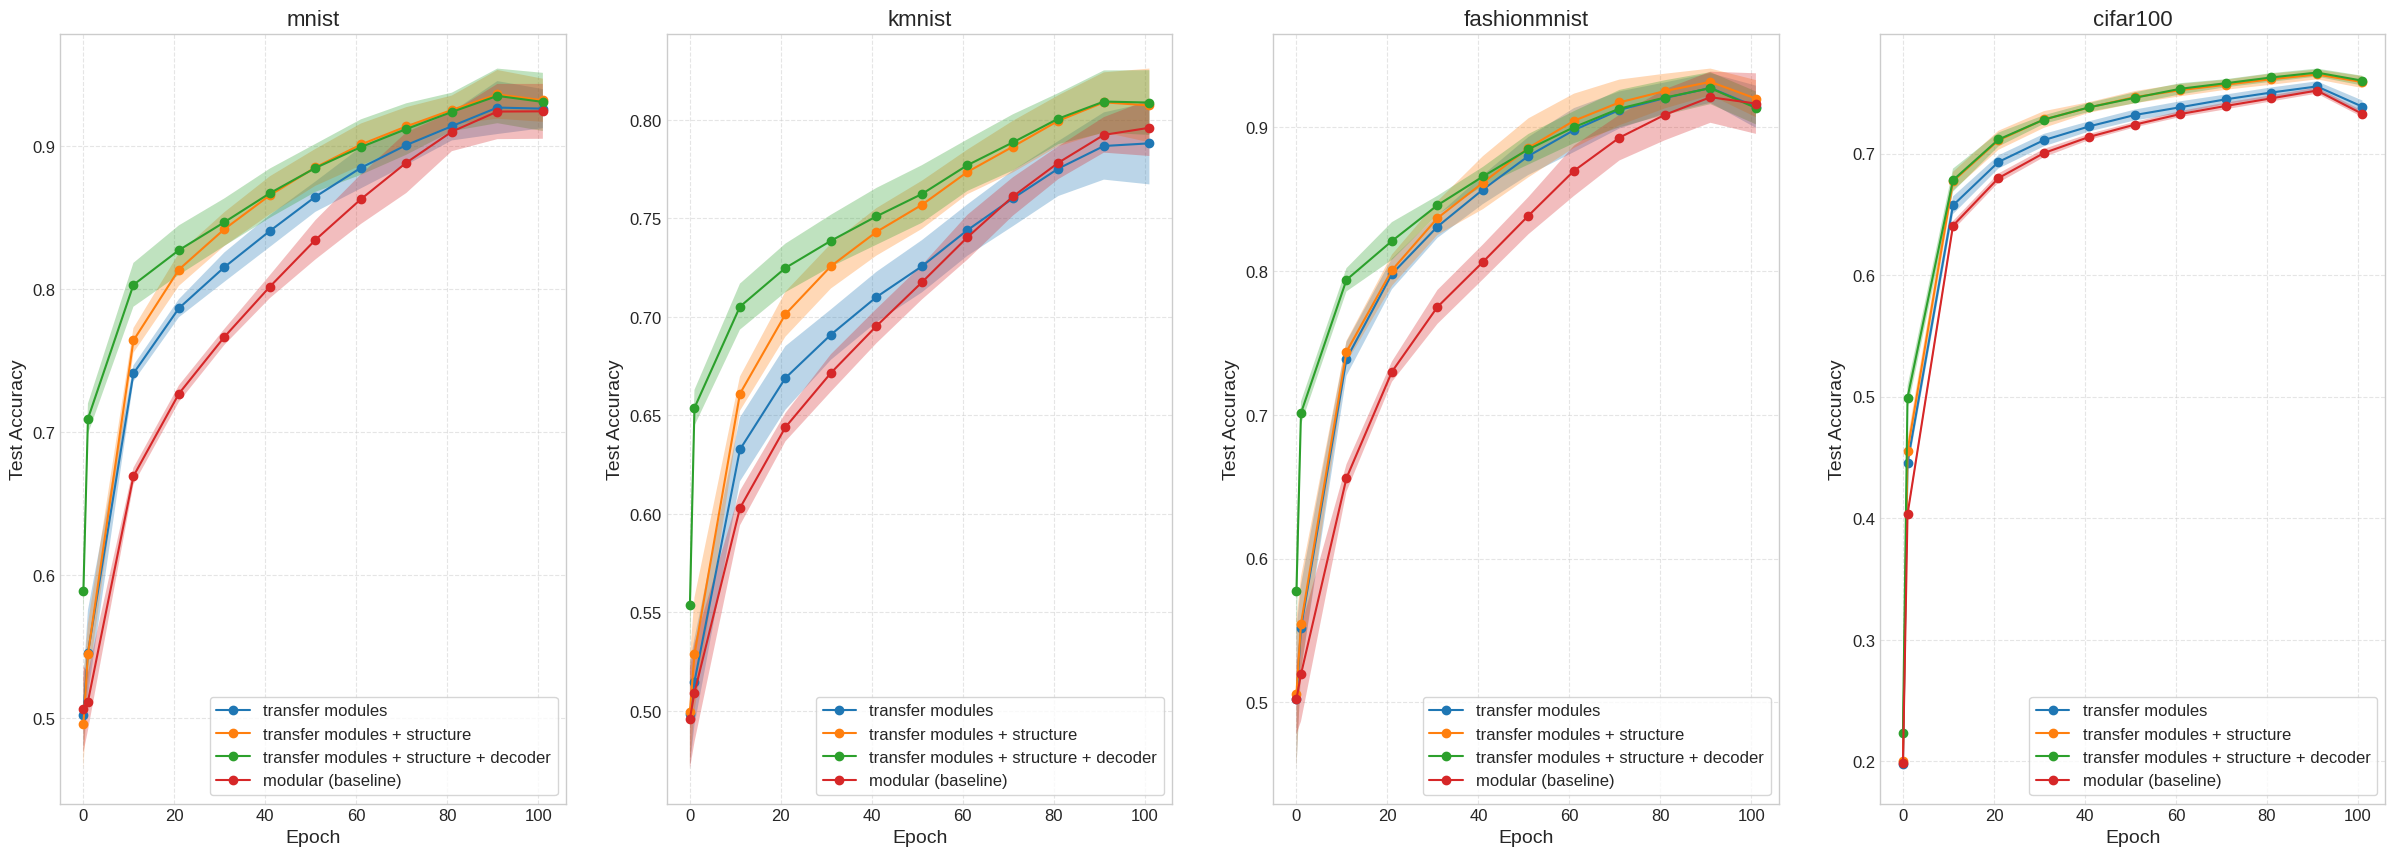

In [11]:
fig, ax = plt.subplots(1, len(dataset_agg_dfs.keys()), figsize=(30, 10))
for i, (dataset, agg_df) in enumerate(dataset_agg_dfs.items()):
    plot_agg_over_seeds(agg_df, title_name=dataset, ax=ax if not isinstance(ax, np.ndarray) else ax[i],metric=metric,
    remap_name=remap_name)



 mnist
modular_no_sparse_basis_True: Average AUC = 81.52
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True: Average AUC = 87.83
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_False_no_sparse_basis_True: Average AUC = 85.73
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True: Average AUC = 86.36
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True: Average AUC = 84.62


 kmnist
modular_no_sparse_basis_True: Average AUC = 71.07
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True: Average AUC = 76.49
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_False_no_sparse_basis_True: Average AUC = 73.99
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_s

/tmp/ipykernel_4019930/283285352.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha="right")  # Align labels to the right


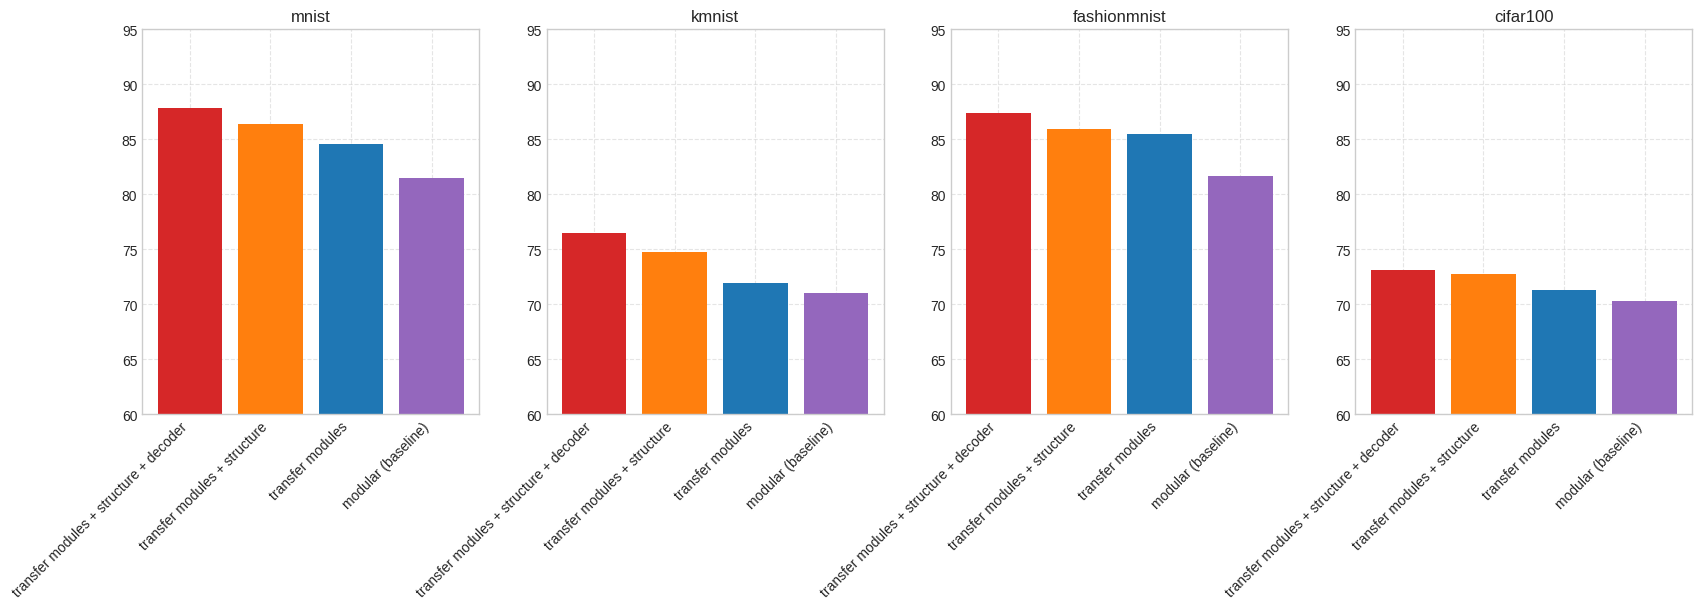

In [12]:
fig, ax = plt.subplots(1, len(dataset_seed_aucs.keys()), figsize=(20, 5))
for i, (dataset, seed_aucs) in enumerate(dataset_seed_aucs.items()):
    print('\n\n', dataset)
    plot_learning_curve_bars(seed_aucs, title_name=dataset,  ax=ax if not isinstance(ax, np.ndarray) else ax[i],
    remap_name=remap_name)